# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tuning

## VGG-16 Model
  * University of Oxford - Visual Geometry Group
  * 2014 ILSVRC 2nd Model
  * ImageNet Large Scale Visual recognition Challenge (ILSVRC)

# Import Keras

In [1]:
import keras

keras.__version__

'2.4.3'

# I. Google Drive Mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 마운트 결과 확인
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [4]:
# unzip
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip


Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [5]:
!ls -l

total 20
drwx------ 5 root root 4096 Mar 24 06:52 drive
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 4 root root 4096 Mar 24 06:52 test
drwxr-xr-x 4 root root 4096 Mar 24 06:52 train
drwxr-xr-x 4 root root 4096 Mar 24 06:52 validation


# II. Image_File Directory Setting

In [6]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'


# III. Data Preprocessing

> ## 1) ImageDataGenerator() & flow_from_directory

* Normalization
  * ImageDataGenerator( )
* Resizing & Generator
  * flow_from_directory()

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
     valid_dir,
     target_size = (150, 150),
     batch_size = 20,
     class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model & Some Layers Freezing

> ## 1) conv_base

In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top =False,
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


> ## 2) Model Information

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> ## 3) 'block5_conv1' Freezing

In [10]:
# Before 'weight' Freezing

print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 26


In [11]:
# 'weight' Freezing

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# After 'weight' Freezing

print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))


conv_base 동결 후 훈련 가능 가중치의 종류: 6


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# V. Keras CNN Modeling with VGG-16 Freezed Layers

> ## 1) Model Define

In [15]:
# 'conv_base' & 'Classification' Network
# Dropout Layer

from keras import models, layers
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


> ## 2) Model Compile 

* 모델 학습방법 설정
  * 이미 학습된 Weight 값을 Tuning
  * 매우 작은 Learning Rate 지정
  * optimizers.Adam(lr = 0.000005)

In [19]:
from keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit (K80)

In [20]:
%%time
Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)


Epoch 1/100
100/100 [==============================] - 46s 114ms/step - loss: 0.7223 - accuracy: 0.5738 - val_loss: 0.4536 - val_accuracy: 0.8340
Epoch 2/100
100/100 [==============================] - 11s 110ms/step - loss: 0.4277 - accuracy: 0.8099 - val_loss: 0.3415 - val_accuracy: 0.8600
Epoch 3/100
100/100 [==============================] - 11s 111ms/step - loss: 0.3230 - accuracy: 0.8638 - val_loss: 0.2793 - val_accuracy: 0.8840
Epoch 4/100
100/100 [==============================] - 11s 111ms/step - loss: 0.2260 - accuracy: 0.9040 - val_loss: 0.2546 - val_accuracy: 0.8940
Epoch 5/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1879 - accuracy: 0.9343 - val_loss: 0.2192 - val_accuracy: 0.9110
Epoch 6/100
100/100 [==============================] - 11s 111ms/step - loss: 0.1396 - accuracy: 0.9564 - val_loss: 0.2081 - val_accuracy: 0.9120
Epoch 7/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1197 - accuracy: 0.9547 - val_loss: 0.2186 -

> ## 4) 학습 결과 시각화

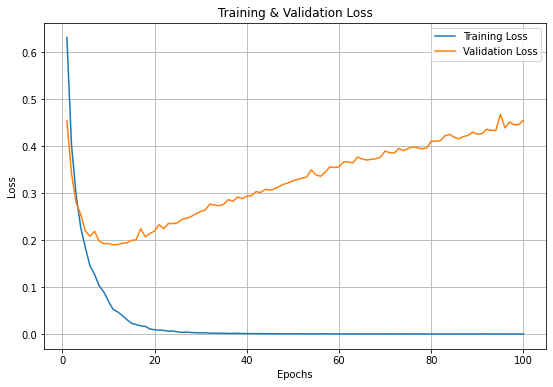

In [21]:
# Loss Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


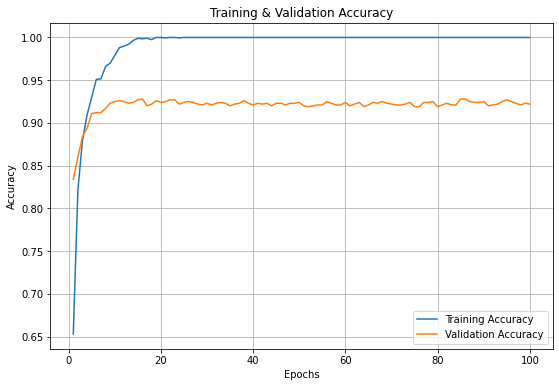

In [22]:
# Accuracy Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()



> ## 5) Model Evaluate

In [24]:
# test_generator
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')


Found 1000 images belonging to 2 classes.


In [26]:
# Loss & Accruacy

loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 4s 69ms/step - loss: 0.3984 - accuracy: 0.9300
Loss = 0.39837
Accuracy = 0.93000


# IV. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [27]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## 2) Model Save

In [28]:
model.save('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 216957
-rw------- 1 root root     34592 Mar 17 07:36 001_Model_iris.h5
-rw------- 1 root root  39879924 Mar 23 04:48 002_dogs_and_cats_small.h5
-rw------- 1 root root  41499744 Mar 23 06:39 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 140748416 Mar 24 07:28 004_dogs_and_cats_feature_extraction.h5


> ## 3) Model Load

In [30]:
from keras.models import load_model

model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 4s 71ms/step - loss: 0.3984 - accuracy: 0.9300
Loss = 0.39837
Accuracy = 0.93000
